# Weather Dataset Preprocessing

In [59]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns


from utils import *

datasets_folder = './datasets'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
weather_folder = os.path.join(datasets_folder,'weather')

weather_df = merge_csv_to_dataframe(weather_folder).rename(columns={'PragaTime':'Date'})
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
weather_df = weather_df.set_index('Date')
weather_df

Merged 6 CSV files


,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,W_VEC_INT,LEAFW,ET0
Date,,,,,,,,,
2019-01-01 00:00:00,1.0,0.0,92.3,0.0,0.5,208.7,0.3,0.0,0.0
2019-01-01 01:00:00,0.3,0.0,93.6,0.0,0.5,280.0,0.2,0.0,0.0
2019-01-01 02:00:00,0.7,0.0,91.7,0.0,1.1,158.1,1.0,0.0,0.0
2019-01-01 03:00:00,0.4,0.0,91.5,0.0,0.7,189.4,0.4,0.0,0.0
2019-01-01 04:00:00,1.0,0.0,86.3,0.0,0.7,172.9,0.6,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2024-12-30 20:00:00,6.2,0.0,72.1,0.0,2.0,268.9,1.6,0.0,0.0
2024-12-30 21:00:00,5.6,0.0,76.1,0.0,2.5,258.0,2.4,0.0,0.0
2024-12-30 22:00:00,5.7,0.0,75.3,0.0,2.8,254.1,2.7,0.0,0.0


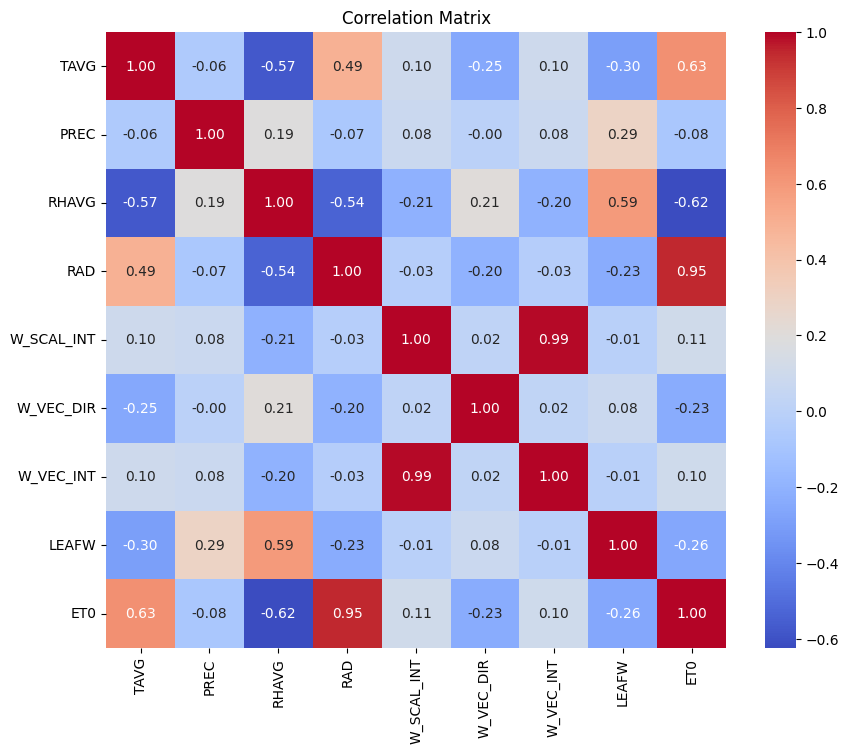

In [61]:
correlation_matrix = weather_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

W_VEC_INT is useless since that we have intensity and direction.

Do we drop ET0?

In [ ]:
weather_df = weather_df.drop(columns=['W_VEC_INT','ET0'])

The last 23 hours of the 2024 are missing...

There are no missing values nor missing hours inbetween:

In [63]:
weather_df.resample('1h')
weather_df.isna().sum()

TAVG          0
PREC          0
RHAVG         0
RAD           0
W_SCAL_INT    0
W_VEC_DIR     0
LEAFW         0
ET0           0
dtype: int64

**Example** of how the dataset gets converted to represent the days.

In [64]:
start = datetime(2019,1,1)
end = datetime(2019,1,2)

one_day_df = weather_df[(weather_df.index>=start)&(weather_df.index<end)]
one_day_df

,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,ET0
Date,,,,,,,,
2019-01-01 00:00:00,1.0,0.0,92.3,0.0,0.5,208.7,0.0,0.0
2019-01-01 01:00:00,0.3,0.0,93.6,0.0,0.5,280.0,0.0,0.0
2019-01-01 02:00:00,0.7,0.0,91.7,0.0,1.1,158.1,0.0,0.0
2019-01-01 03:00:00,0.4,0.0,91.5,0.0,0.7,189.4,0.0,0.0
2019-01-01 04:00:00,1.0,0.0,86.3,0.0,0.7,172.9,0.0,0.0
2019-01-01 05:00:00,2.3,0.0,79.7,0.0,1.8,151.0,0.0,0.0
2019-01-01 06:00:00,-0.2,0.0,85.3,0.0,1.8,338.7,0.0,0.0
2019-01-01 07:00:00,-0.1,0.0,86.6,0.0,2.1,297.5,0.0,0.0
2019-01-01 08:00:00,0.4,0.0,83.8,49.7,3.9,272.4,0.0,0.0


- LEAFW should be 9 (number of positive elements)
- TAVG AND RHAVG should be split in max and min
- ET0 should be 0.4 (sum)

In [73]:
transform_weather_to_daily_df(one_day_df)

,PREC,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,ET0,TAVG_MAX,TAVG_MIN,RHAVG_MAX,RHAVG_MIN
Date,,,,,,,,,,
2019-01-01,0.0,1560.5,2.458333,274.482833,9,0.4,3.7,-0.2,99.1,79.7
